# kNN

This notebook is for practical implementations of kNN. For the relevant theory, please refer to the Supervised Learning workbook (link to be added).

## Algorithm

## Implementation

In [124]:
def euclidean_dist(arr1, arr2):
    dist = 0
    for x1, x2 in zip(arr1, arr2):
        dist += (x1-x2)**2
    return dist**0.5



class kNN:
    def __init__(self, k, metric, algorithm = 'brute'):
        self.k = k
        self.metric = metric
        self.algorithm = algorithm
    
    def fit(self, X, y):
        
        # depending on the type of algorithm that you want to go for, the fit function
        # should generate the necessary data structures!
        
        if self.algorithm == 'brute':
            self.X = X
            self.y = y
    
    def predict(self, X):
        # maybe the output should also be a numpy array? Not a list?
        
        y_pred = []
        for x_test in X:
            dist = [self.metric(x_test, x_train) for x_train in self.X] 
            dist, y = zip(*sorted(zip(dist, self.y)))
            y = y[:self.k]
            y_pred.append(max(y,key=y.count))
        return y_pred

## Example

- The fit function normally does some training, but in the case of a simple implementation kNN, this has the purpose of simply storing the data. For more info click [here](https://stats.stackexchange.com/questions/349842/why-do-we-need-to-fit-a-k-nearest-neighbors-classifier)
- make sure to use the log(nsamples) to estimate which k to use
- add stuff about evaluating the algorithm, error, cross validation, plot of the voronoi cells ?

In [167]:
# relevant modules

from sklearn.datasets import load_iris
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import numpy as np

# util functions
def plot_classes(X, y):
    for i in np.unique(y):
        plt.plot(X[y == i, 0], X[y == i, 1], '.')
    plt.xlabel('Principal Component 1')
    plt.ylabel('Principal Component 2')
    
def plot_contour(X, y, fitted_model, *xlim):
    xlim = [np.linspace(*xlim_) if isinstance(xlim_, tuple) else np.linspace(min(xlim_), max(xlim_), len(xlim_)) for xlim_ in xlim]
    X_grid = [grid.reshape(-1,1) for grid in np.meshgrid(*xlim)]
    X_grid = np.concatenate(tuple(X_grid), axis = 1)    
    y_pred = np.array(fitted_model.predict(X_grid))
    plt.contour(*xlim, y_pred.reshape(*[len(xlim_) for xlim_ in xlim]))
    

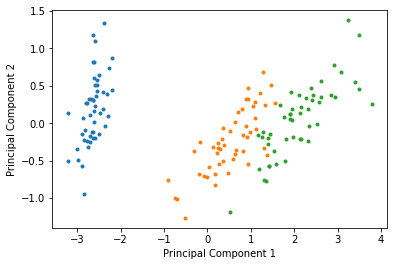

In [148]:
# load the dataset
X,y = load_iris(return_X_y = True)

# reduce dataset size to have 2 dimensions only
model = PCA(2)
X = model.fit_transform(X)

# visualize plot
plot_classes(X, y)

((-4, 4, 50), (-1.5, 1.5, 50))
(2500, 2)


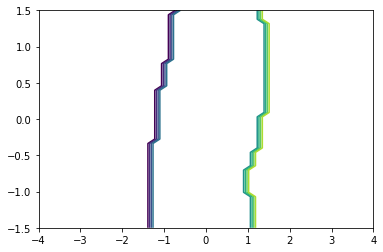

In [168]:
"""
x1_ = np.linspace(-4,4, 50)
x2_ = np.linspace(-1.5, 1.5, 50)
x1, x2 = np.meshgrid(x1_, x2_)
x1 = x1.reshape(-1,1)
x2 = x2.reshape(-1,1)
X_grid = np.concatenate((x1, x2), axis = 1)

model = kNN(30, euclidean_dist)

model.fit(X, y)
print('model fitted')
y_pred = np.array(model.predict(X_grid))
print('model predicted')
plt.contourf(x1_, x2_, y_pred.reshape(-50,50))
plot_classes(X, y)"""

model = kNN(30, euclidean_dist)

model.fit(X, y)

plot_contour(X, y, model, (-4,4, 50), (-1.5, 1.5, 50))

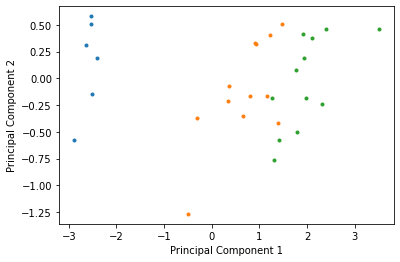

In [73]:
model = kNN(1, euclidean_dist)
model.fit(X_train, y_train)
y_pred = model.predict(X_test)
plot_classes(X_test, y_pred)

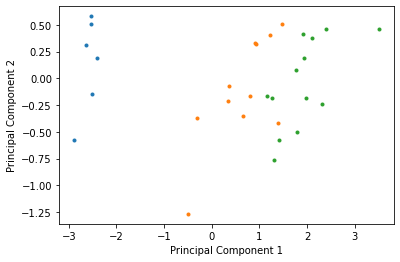

In [74]:
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size = 0.2)

# Useful Links

https://stats.stackexchange.com/questions/485884/bias-and-variance-in-knn-and-decision-trees
https://stats.stackexchange.com/questions/107870/does-k-nn-with-k-1-always-implies-overfitting
https://stackoverflow.com/questions/5751114/nearest-neighbors-in-high-dimensional-data
https://stackoverflow.com/questions/33508247/how-to-handle-duplicate-data-points-in-k-nearest-neighbor-algorithm